<div style="font-size: 13px; line-height: 1.4; margin: 0; padding: 0;">
<h5 style="margin-bottom: 0.2em;">
This notebook documents my theoretical study alongside the lab exercises conducted on <b>July 7, 2025</b>.
</h5>
</div>

### <u style="margin-bottom: 0;">**LAB EXERCISES**</u>

### **WEEK 4**

#### <code>**day3.ipynb**</code>

<div style="font-size: 14px; line-height: 1.4; margin: 0; padding: 0;">
<h5 style="margin-bottom: 0.2em;"><b>Lab Exercises</b></h5>
<b>1/</b> Rerun <code>day3.ipynb</code> with <b>OpenAI</b> & <b>Ollama</b><br>

In [ ]:
# Prerequisites:
# 1. Fetch last code from Dr.Donner
# Run this in the Anaconda Prompt or terminal:
# Change to the correct directory first
# conda env update --f environment.yml --prune   
# or if you are using pip
# !pip install -r requirements.txt

In [ ]:
# 2. Install the required packages & dependencies
# %pip install python-dotenv
# %pip install pydantic-core

In [ ]:
# Imports
import os
import io
import sys
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai
import anthropic
from IPython.display import Markdown, display, update_display
import gradio as gr
import subprocess

In [ ]:
# Environment
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [ ]:
# Initialize clients
openai = OpenAI()
ollama_via_openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')

# Model configuration
OPENAI_MODEL = "gpt-4o-mini"
OLLAMA_MODEL = "llama3.2"

# Configure Gemini if available
google_api_key = os.getenv('GOOGLE_API_KEY')
GEMINI_AVAILABLE = False

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
    google.generativeai.configure(api_key=google_api_key)
    
    gemini_via_openai = OpenAI(
        api_key=google_api_key,
        base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
    )
    
    GEMINI_MODEL = "gemini-1.5-flash"
    GEMINI_AVAILABLE = True
    print("Google Gemini configured successfully")
else:
    print("Google API Key not set")

In [ ]:
# Original prompt
# system_message = "You are an assistant that reimplements Python code in high performance C++ for an M1 Mac. "
# system_message += "Respond only with C++ code; use comments sparingly and do not provide any explanation other than occasional comments. "
# system_message += "The C++ response needs to produce an identical output in the fastest possible time."

# GPT 
system_message = "You are an assistant that reimplements Python code in high performance C++ for Windows. "
system_message += "Always include ALL necessary headers: #include <iostream>, #include <chrono>, #include <cstdint>, #include <limits>, #include <iomanip>. "
system_message += "Use standard C++ without explanatory text - only code with occasional comments using //. "
system_message += "Never include explanations or notes outside of comments. "
system_message += "Use simple number format without separators (write 100000000 not 100_000_000). "
system_message += "For 2^32, use uint64_t type consistently throughout the code to avoid overflow. "
system_message += "Ensure all variable types match their usage (e.g., if constructor parameter is uint64_t, member variable should also be uint64_t). "
system_message += "Avoid undefined behavior like bit shifts that exceed type width (use 1ULL << 32 not 1u << 32). "
system_message += "Ensure the algorithm matches the Python code exactly. "
system_message += "Respond only with valid C++ code that compiles without errors. "
system_message += "The C++ response needs to produce an identical output in the fastest possible time."

# Ollama 
# system_message_ollama = (
#     "You are an assistant that reimplements Python code in high performance C++ for Windows. "
#     "Always include ALL necessary headers: #include <iostream>, #include <chrono>, #include <cstdint>, #include <limits>, #include <iomanip>, #include <vector>, #include <cmath>. "
#     "Never use or invent types that do not exist in standard C++ (such as uint128_t, uint256_t, etc). Only use uint64_t, int64_t, double, etc. "
#     "Never use numeric literals with underscores (such as 10_000_000). Use only standard C++ number literals (such as 10000000). "
#     "Never use template syntax like vector<int64_t>::size in numeric_limits or anywhere else. "
#     "Never define or overload operators for built-in types (such as operator% for uint64_t). "
#     "Never use custom namespaces or templates. "
#     "Never use Python-specific syntax or keywords like 'yield'. "
#     "Never use invalid casts or pointer casts in arithmetic. Only use static_cast for valid type conversions. "
#     "Never use user-defined literals or literal suffixes that are not standard C++ (such as 100_000_000 or 10ms). "
#     "Never use static member functions or static operator() in classes unless absolutely required by C++17. "
#     "Never use old-style base class initializers or unnamed initializers in constructors. "
#     "All variables, constants, and functions must be declared and defined within their accessible scope *before* their first use. This includes any constants (e.g., J, K) which should be declared as const variables in an appropriate scope (e.g., global, namespace, or function scope). "
#     "Never use or invent any function, variable, or type that is not explicitly defined in the code. "
#     "Never use or invent any identifier that is not valid C++17. "
#     "Never use single quotes for string output (use double quotes for string literals). "
#     "Always use std:: for standard library functions and manipulators (e.g., std::fixed, std::setprecision). "
#     "For random number generation, only use a custom linear congruential generator (LCG) if the Python code uses it. Never use <random> or std::mt19937_64 unless the Python code uses them. "
#     "For generators, use simple classes with next() methods, not complex iterators. "
#     "Use simple number format without separators (write 4294967296ULL not 4_294_967_296). "
#     "For 2^32, use uint64_t consistently: uint64_t m = 4294967296ULL. "
#     "Use int64_t for values that can be negative (like min_val = -10). "
#     "Never increment const references or use undefined functions or variables. "
#     "Match variable names exactly from function parameters. "
#     "Avoid complex template structures - use simple classes instead. "
#     "Ensure the algorithm matches the Python code exactly with simple, readable C++. "
#     "Only use standard library functions - no custom undefined functions. "
#     "All code must compile with g++ using -std=c++17 and must not require any C++20 or later features. "
#     "Never use any feature or syntax not supported by C++17. "
#     "For custom numeric types (e.g., Int64), ensure non-explicit constructors are provided for implicit conversions from standard integer types like int64_t and uint64_t (e.g., `Int64(uint64_t val)`). "
#     "If a custom class has private data members that need external access, provide public getter methods (e.g., `long long getValue() const;`) or public conversion operators (e.g., `operator int64_t() const;`) to expose the underlying value. "
#     "For custom numeric types, explicitly overload all necessary arithmetic and comparison operators (e.g., +, -, *, /, %, ==,!=, <, <=, >, >=) to support interactions with both other custom types and built-in types (int64_t, uint64_t, double). Ensure symmetric operations (e.g., `CustomType op BuiltInType` and `BuiltInType op CustomType`) are supported, potentially using non-member functions. "
#     "For floating-point modulo operations, always use `std::fmod` from the `<cmath>` header. The `%` operator is strictly for integer types only. "
#     "Respond only with valid C++ code that compiles without errors or warnings. "
# )

# system_message_ollama = ("You are an assistant that reimplements Python code in high-performance C++ for Windows. Include necessary headers like <iostream>, <chrono>, <cstdint>, <limits>, <iomanip>. Use standard C++ without explanatory text, only code with occasional comments. Use simple number formats without separators. Use uint64_t for large numbers to avoid overflow. Ensure the algorithm matches the Python code exactly. Respond only with valid C++ code that compiles without errors and produces identical output efficiently.")

# system_message_ollama = (
#     "You are a high-performance Python-to-C++ reimplementation assistant for Windows. Always include all necessary headers: #include <iostream>, #include <chrono>, #include <cstdint>, #include <limits>, #include <iomanip>, #include <vector>, #include <cmath>. "
#     "Avoid using or inventing types that do not exist in standard C++ (such as uint128_t, uint256_t). Only use uint64_t, int64_t, double, etc. "
#     "Do not include numeric literals with underscores (such as 10_000_000), but rather only use standard C++ number literals (such as 10000000). "
#     "Avoid using template syntax like vector<int64_t>::size in numeric_limits or anywhere else. "
#     "Do not define or overload operators for built-in types, such as operator% for uint64_t. "
#     "Avoid custom namespaces and templates unless absolutely required by C++17. "
#     "Avoid Python-specific keywords (such as 'yield'). Avoid invalid casts or pointer casts in arithmetic; only use static_cast for valid type conversions. "
#     "Avoid using user-defined literals, literal suffixes that are not standard C++, such as 100_000_000 or 10ms)."
#     "Avoid old-style base class initializers and unnamed initializers in constructors unless absolutely required by C++17."
#     "All variables, constants, functions must be declared before their first use. This includes any constants (e.g., J, K) which should be declared as const variables within an appropriate scope such as global, namespace or function scope."
#     "Avoid using custom types that are not explicitly defined in the code and avoid invalid identifiers outside of C++17 standards."
#     "Use double quotes for string literals instead of single quotes. Always use std:: for standard library functions and manipulators (e.g., std::fixed, std::setprecision)."
#     "For random number generation: only allow custom linear congruential generators if the Python code uses it; never include <random> or std::mt19937_64 unless required by python."
#     "Use simple classes with next() methods for generators instead of complex iterators. Use int64_t consistently when dealing with 2^32 and use uint64_t only if necessary, such as in min_val = -10."
#     "Avoid incrementing const references or using undefined functions or variables; match variable names exactly from function parameters to prevent confusion between different scopes of the code. "
#     "Prefer simple structures over complex templates when possible – try not to use them unless absolutely required by C++17 standards." 
#     "Ensure that algorithms are identical in both Python and generated C++ versions, written with simplicity for readability."
#     "Only include standard library functions; no custom undefined ones should be used. All code must compile successfully using g++ -std=c++17 without requiring any features or syntax beyond c++17 standards." 
#     "For custom numeric types (e.g., Int64), provide non-explicit constructors for implicit conversions from standard integer types like int64\_t and uint64\_t, such as Int64(uint64\_t val)."
#     "If a custom class has private data members that need external access, offer public getter methods (e.g., long long getValue() const;) or public conversion operators (e.g., operator int64\_t() const;)"
#     "For custom numeric types: explicitly overload all necessary arithmetic and comparison operators (e.g., +, -, *, /, %, ==, !=, <, <=, >, >=) to support interactions with both other custom types as well as built-in ones like int64\_t or uint64\_t. Ensure symmetric operations are supported too – e.g., CustomType op BuiltInType and BuiltInType op CustomType."
#     "For floating-point modulo operations: always use std::fmod from the <cmath> header instead of % operator which is strictly for integer types only." 
#     "Provide valid C++ code that compiles without errors or warnings. "
# )

system_message_ollama = (
    "You are an assistant that reads Python code and rewrites it in idiomatic, high-performance C++17 for Windows. "
    "Your sole output must be a complete, compilable C++ file that compiles cleanly under "
    "`g++ -O3 -std=c++17` with zero errors and zero warnings. "
    "Output only valid C++17 code with no additional commentary, notes, or explanations. "
    "Follow best practices for readability, performance, and safety. "

    "Use only C++17 syntax and the C++ Standard Library. "
    "Never introduce non-standard types or functions. "
    "Match variable types precisely to their usage (`uint64_t` for large unsigned, `int64_t` for signed, `double` for floating-point). "
    "Declare every variable before its first use. "

    "Replace Python lists and comprehensions with `std::vector` and C++ loops. "
    "Replace Python generators and `yield` with explicit C++ classes or functions exposing a `next()` method. "
    "Replace Python’s `range` with classic `for (std::size_t i = ...)` loops. "
    "For exponentiation, use `std::pow` or bit-shifts; never use `**`. "
    "For numeric literals, omit underscores or apostrophes (e.g., use `10000000`, not `10_000_000`). "

    "Include all required headers explicitly: "
    "<iostream>, <vector>, <cstdint>, <chrono>, <iomanip>, and any others needed. "
    "Do not omit or forward-declare standard headers. "

    "If the Python code uses random number generation, implement a C++ class with a constructor for seed/parameters and a `uint32_t next()` or `operator()()` method. "
    "Do not use coroutines or generator syntax. "

    "For timing, use `std::chrono::high_resolution_clock` and `std::chrono::duration_cast` to microseconds or milliseconds, then "
    "print via `std::cout << \"Execution Time: \" << elapsed << \" µs\\n\";`. "
    "Use `<iomanip>` for formatting when necessary. "

    "All code must compile as a single `.cpp` file with `g++ -O3 -std=c++17 your_file.cpp -o your_program` "
    "and produce zero warnings under `-Wall -Wextra`. "
    "Output only the complete C++17 code, nothing else."
)

# Gemini 
if GEMINI_AVAILABLE:
    system_message_gemini = "You are an assistant that reimplements Python code in high performance C++ for Windows. "
    system_message_gemini += "Always include ALL necessary headers: #include <iostream>, #include <chrono>, #include <cstdint>, #include <limits>, #include <iomanip>. "
    system_message_gemini += "Use standard C++ without explanatory text - only code with occasional comments using //. "
    system_message_gemini += "Never include explanations or notes outside of comments. "
    system_message_gemini += "Use simple number format without separators (write 100000000 not 100_000_000). "
    system_message_gemini += "For 2^32, use uint64_t type consistently throughout the code to avoid overflow. "
    system_message_gemini += "Ensure all variable types match their usage. "
    system_message_gemini += "Avoid undefined behavior like bit shifts that exceed type width. "
    system_message_gemini += "Ensure the algorithm matches the Python code exactly. "
    system_message_gemini += "Respond only with valid C++ code that compiles without errors. "
    system_message_gemini += "The C++ response needs to produce an identical output in the fastest possible time."

In [ ]:
def user_prompt_for(python):
    user_prompt = "Rewrite this Python code in C++ with the fastest possible implementation that produces identical output in the least time. "
    user_prompt += "Respond only with C++ code; do not explain your work other than a few comments. "
    user_prompt += "Pay attention to number types to ensure no int overflows. Remember to #include all necessary C++ packages such as iomanip.\n\n"
    user_prompt += python
    return user_prompt

In [ ]:
def messages_for(python):
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt_for(python)}
    ]

In [ ]:
def messages_for_ollama(python):
    return [
        {"role": "system", "content": system_message_ollama},
        {"role": "user", "content": user_prompt_for(python)}
    ]

In [ ]:
def messages_for_gemini(python):
    if GEMINI_AVAILABLE:
        return [
            {"role": "system", "content": system_message_gemini},
            {"role": "user", "content": user_prompt_for(python)}
        ]
    return []

In [ ]:
def write_output(cpp, filename="optimized.cpp"):
    code = cpp.replace("```cpp","").replace("```","")
    
    lines = code.split('\n')
    cleaned_lines = []
    for line in lines:
        stripped = line.strip()
        if (not stripped.startswith('Note that') and 
            not stripped.startswith('The ') and
            not stripped.startswith('This ') and
            '`' not in stripped): 
            cleaned_lines.append(line)
    
    cleaned_code = '\n'.join(cleaned_lines)
    
    with open(filename, "w") as f:
        f.write(cleaned_code)

In [ ]:
def execute_python(code):
    try:
        output = io.StringIO()
        sys.stdout = output
        exec(code)
    finally:
        sys.stdout = sys.__stdout__
    return output.getvalue()

In [ ]:
def execute_cpp(code):
    write_output(code, "optimized.cpp")
    try:
        compile_cmd = ["g++", "-O3", "-std=c++17", "-o", "optimized.exe", "optimized.cpp"]
        compile_result = subprocess.run(compile_cmd, check=True, text=True, capture_output=True)
        
        run_cmd = ["optimized.exe"]
        run_result = subprocess.run(run_cmd, check=True, text=True, capture_output=True)
        return run_result.stdout
    except subprocess.CalledProcessError as e:
        return f"An error occurred:\n{e.stderr}"

In [ ]:
def optimize_model(python, model_name, system_msg, messages_func, client, output_file):
    stream = client.chat.completions.create(
        model=model_name, 
        messages=messages_func(python), 
        stream=True
    )
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        print(fragment, end='', flush=True)
    write_output(reply, output_file)

<br>

<div style="font-size: 14px; line-height: 1.5; margin: 0; padding: 0;">
<b style="font-size: 16px;">Problem 1:</b> Calculate <b>π</b> (PI number)<br>
</div>

In [ ]:
def optimize_gpt(python):
    optimize_model(
        python=python,
        model_name=OPENAI_MODEL,
        system_msg=system_message,
        messages_func=messages_for,
        client=openai,
        output_file="optimized_gpt.cpp"
    )

In [ ]:
def optimize_ollama(python):
    optimize_model(
        python=python,
        model_name=OLLAMA_MODEL,
        system_msg=system_message_ollama,
        messages_func=messages_for_ollama,
        client=ollama_via_openai,
        output_file="optimized_ollama.cpp"
    )

In [ ]:
def optimize_gemini(python):
    if not GEMINI_AVAILABLE:
        print("Gemini not available - Google API key not set")
        return
        
    reply = ""
    for stream_chunk in stream_gemini(python):
        reply = stream_chunk
        print(stream_chunk[len(reply)-len(stream_chunk):], end='', flush=True) if len(stream_chunk) > len(reply) else None
    
    write_output(reply, "optimized_gemini.cpp")

<br>

<div style="font-size: 14px; line-height: 1.5; margin: 0; padding: 0;">
<!-- <b style="font-size: 16px;">Problem 2 & 3:</b> Find the <b>Maximum Subarray Sum </b>and with Gradio UI<br> -->
<b style="font-size: 16px;">Problem 2:</b> Find the <b>Maximum Subarray Sum </b><br>
</div>


In [ ]:
# Streaming
def stream_gpt(python):    
    stream = openai.chat.completions.create(
        model=OPENAI_MODEL, 
        messages=messages_for(python), 
        stream=True
    )
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        yield reply.replace('```cpp\n','').replace('```','')

In [ ]:
# Streaming
def stream_ollama(python):    
    stream = ollama_via_openai.chat.completions.create(
        model=OLLAMA_MODEL, 
        messages=messages_for_ollama(python), 
        stream=True
    )
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        yield reply.replace('```cpp\n','').replace('```','')

In [ ]:
# Streaming
def stream_gemini(python):
    if not GEMINI_AVAILABLE:
        yield "Gemini not available - Google API key not set"
        return
        
    try:
        stream = gemini_via_openai.chat.completions.create(
            model=GEMINI_MODEL,
            messages=messages_for_gemini(python),
            stream=True
        )
        reply = ""
        for chunk in stream:
            fragment = chunk.choices[0].delta.content or ""
            reply += fragment
            yield reply.replace('```cpp\n','').replace('```','')
            
    except Exception as e:
        print(f"OpenAI-compatible endpoint failed: {e}")
        try:
            gemini = google.generativeai.GenerativeModel(
                model_name='gemini-1.5-flash',
                system_instruction=system_message_gemini
            )
            response = gemini.generate_content(
                user_prompt_for(python),
                stream=True
            )
            reply = ""
            for chunk in response:
                if chunk.text:
                    reply += chunk.text
                    yield reply.replace('```cpp\n','').replace('```','')
        except Exception as e2:
            yield f"Gemini Error: {str(e2)}"

In [ ]:
model_options = ["GPT", "Ollama"]
if GEMINI_AVAILABLE:
    model_options.append("Gemini")
print(f"Available models: {model_options}")

def optimize(python, model):
    if model=="GPT":
        result = stream_gpt(python)
    elif model=="Ollama":
        result = stream_ollama(python)
    elif model=="Gemini" and GEMINI_AVAILABLE:
        result = stream_gemini(python)
    else:
        raise ValueError(f"Unknown model: {model}")  
    for stream_so_far in result:
        yield stream_so_far

In [ ]:
# Helper functions for executing code
def run_test(python_code, optimize_func, compiler_flags=None):
    """Run a complete test with a given optimization function"""
    print(f"=== Executing Python code ===")
    exec(python_code)
    
    print(f"\n=== Optimizing code with {optimize_func.__name__} ===")
    optimize_func(python_code)
    
    if compiler_flags is None:
        compiler_flags = ["-O3", "-std=c++17"]
        
    output_file = f"optimized_{optimize_func.__name__.replace('optimize_', '')}.exe"
    input_file = f"optimized_{optimize_func.__name__.replace('optimize_', '')}.cpp"
    
    print(f"\n=== Compiling {input_file} ===")
    compile_cmd = ["g++"] + compiler_flags + ["-o", output_file, input_file]
    compile_result = subprocess.run(compile_cmd, capture_output=True, text=True)
    if compile_result.returncode != 0:
        print(f"Compilation error: {compile_result.stderr}")
        return
        
    print(f"\n=== Running {output_file} ===")
    run_cmd = [f"./{output_file}"]
    run_result = subprocess.run(run_cmd, capture_output=True, text=True)
    print(run_result.stdout)
    
    return run_result.stdout

In [ ]:
# Problems
# Problem 1: Pi Calculation
pi = """
import time

def calculate(iterations, param1, param2):
    result = 1.0
    for i in range(1, iterations+1):
        j = i * param1 - param2
        result -= (1/j)
        j = i * param1 + param2
        result += (1/j)
    return result

start_time = time.time()
result = calculate(100_000_000, 4, 1) * 4
end_time = time.time()

print(f"Result: {result:.12f}")
print(f"Execution Time: {(end_time - start_time):.6f} seconds")
"""

# Problem 2: Maximum Subarray Sum
python_hard = """# Be careful to support large number sizes

def lcg(seed, a=1664525, c=1013904223, m=2**32):
    value = seed
    while True:
        value = (a * value + c) % m
        yield value
        
def max_subarray_sum(n, seed, min_val, max_val):
    lcg_gen = lcg(seed)
    random_numbers = [next(lcg_gen) % (max_val - min_val + 1) + min_val for _ in range(n)]
    max_sum = float('-inf')
    for i in range(n):
        current_sum = 0
        for j in range(i, n):
            current_sum += random_numbers[j]
            if current_sum > max_sum:
                max_sum = current_sum
    return max_sum

def total_max_subarray_sum(n, initial_seed, min_val, max_val):
    total_sum = 0
    lcg_gen = lcg(initial_seed)
    for _ in range(20):
        seed = next(lcg_gen)
        total_sum += max_subarray_sum(n, seed, min_val, max_val)
    return total_sum

# Parameters
n = 10000         # Number of random numbers
initial_seed = 42 # Initial seed for the LCG
min_val = -10     # Minimum value of random numbers
max_val = 10      # Maximum value of random numbers

# Timing the function
import time
start_time = time.time()
result = total_max_subarray_sum(n, initial_seed, min_val, max_val)
end_time = time.time()

print("Total Maximum Subarray Sum (20 runs):", result)
print("Execution Time: {:.6f} seconds".format(end_time - start_time))
"""

In [ ]:
def execute_python(code):
    try:
        output = io.StringIO()
        sys.stdout = output
        exec(code)
    finally:
        sys.stdout = sys.__stdout__
    return output.getvalue()

In [ ]:
def execute_cpp(code):
    write_output(code, "optimized.cpp")
    try:
        compile_cmd = ["g++", "-O3", "-std=c++17", "-o", "optimized.exe", "optimized.cpp"]
        compile_result = subprocess.run(compile_cmd, check=True, text=True, capture_output=True)
        
        run_cmd = ["optimized.exe"]
        run_result = subprocess.run(run_cmd, check=True, text=True, capture_output=True)
        return run_result.stdout
    except subprocess.CalledProcessError as e:
        return f"An error occurred:\n{e.stderr}"

In [ ]:
css = """
.python {background-color: #306998;}
.cpp {background-color: #050;}
"""

def create_gradio_ui():
    with gr.Blocks(css=css) as ui:
        gr.Markdown("## Convert code from Python to C++")
        with gr.Row():
            python = gr.Textbox(label="Python code:", value=python_hard, lines=10)
            cpp = gr.Textbox(label="C++ code:", lines=10)
        with gr.Row():
            model = gr.Dropdown(model_options, label="Select model", value="GPT")
        with gr.Row():
            convert = gr.Button("Convert code")
        with gr.Row():
            python_run = gr.Button("Run Python")
            cpp_run = gr.Button("Run C++")
        with gr.Row():
            python_out = gr.TextArea(label="Python result:", elem_classes=["python"])
            cpp_out = gr.TextArea(label="C++ result:", elem_classes=["cpp"])

        convert.click(optimize, inputs=[python, model], outputs=[cpp])
        python_run.click(execute_python, inputs=[python], outputs=[python_out])
        cpp_run.click(execute_cpp, inputs=[cpp], outputs=[cpp_out])

    return ui

# Launch the UI
# ui = create_gradio_ui()
# # ui.launch(inbrowser=True)
# ui.launch()

# For debugging
# ui = create_gradio_ui()
# ui.launch(inbrowser=True)
# ui.launch()

In [ ]:
# print("1.1/ Pi Calculation (gpt-4o-mini)")
# print("BEFORE optimization")
# exec(pi)

# print() 

# print("AFTER optimization")
# optimize_gpt(pi)
# !g++ -O3 -std=c++17 -o optimized_gpt.exe optimized_gpt.cpp
# !optimized_gpt.exe

In [ ]:
print("1.2/ Pi Calculation (Llama3.2)")
print("BEFORE optimization")
exec(pi)

print() 

print("AFTER optimization")
optimize_ollama(pi)
try:
    with open("optimized_ollama.cpp", "r") as f:
        code = f.read()
    if code.strip():
        if "#include <vector>" not in code:
            code = code.replace("#include <iomanip>", "#include <iomanip>\n#include <vector>")
        code = code.replace("std::chrono::high_resolution_clock::now()", "std::chrono::high_resolution_clock::now()")
        with open("optimized_ollama.cpp", "w") as f2:
            f2.write(code)
        !g++ -O3 -std=c++17 -fext-numeric-literals -o optimized_ollama.exe optimized_ollama.cpp
        !optimized_ollama.exe
    else:
        print("Ollama did not generate valid C++ code.")
except Exception as e:
    print("Ollama C++ code not found or invalid:", e)

In [ ]:
# if GEMINI_AVAILABLE:
#     print("1.3/ Pi Calculation (gemini-1.5-flash)")
#     print("BEFORE optimization")
#     exec(pi)

#     print()

#     print("AFTER optimization")
#     optimize_gemini(pi)
#     !g++ -O3 -std=c++17 -o optimized_gemini.exe optimized_gemini.cpp
#     !optimized_gemini.exe

In [ ]:
# print("2.1/ Maximum Subarray Sum (gpt-4o-mini)")
# print("BEFORE optimization")
# exec(python_hard)

# print() 

# print("AFTER optimization")
# optimize_gpt(python_hard)
# !g++ -O3 -std=c++17 -o optimized_gpt.exe optimized_gpt.cpp
# !optimized_gpt.exe

In [ ]:
print("2.2/ Maximum Subarray Sum (Llama3.2)")
print("BEFORE optimization")
exec(python_hard)

print() 

print("AFTER optimization")
optimize_ollama(python_hard)
!g++ -O3 -std=c++17 -o optimized_ollama.exe optimized_ollama.cpp
!optimized_ollama.exe

In [ ]:
# if GEMINI_AVAILABLE:
#     print("2.3/ Maximum Subarray Sum (gemini-1.5-flash)")
#     print("BEFORE optimization")
#     exec(python_hard)

#     print() 

#     print("AFTER optimization")
#     optimize_gemini(python_hard)
#     !g++ -O3 -std=c++17 -o optimized_gemini.exe optimized_gemini.cpp
#     !optimized_gemini.exe

<br>

<div style="font-size: 14px; line-height: 1.5; margin: 0; padding: 0;">
<b style="font-size: 16px;">Problem 3:</b> Total Maximum Subarray Sum <b>(with Gradio UI)</b><br>
</div>

<div style="font-size: 14px; line-height: 1.5; margin: 0; padding: 0;">
<b>For <code>gpt-4o-mini</code></b><br>
</div>

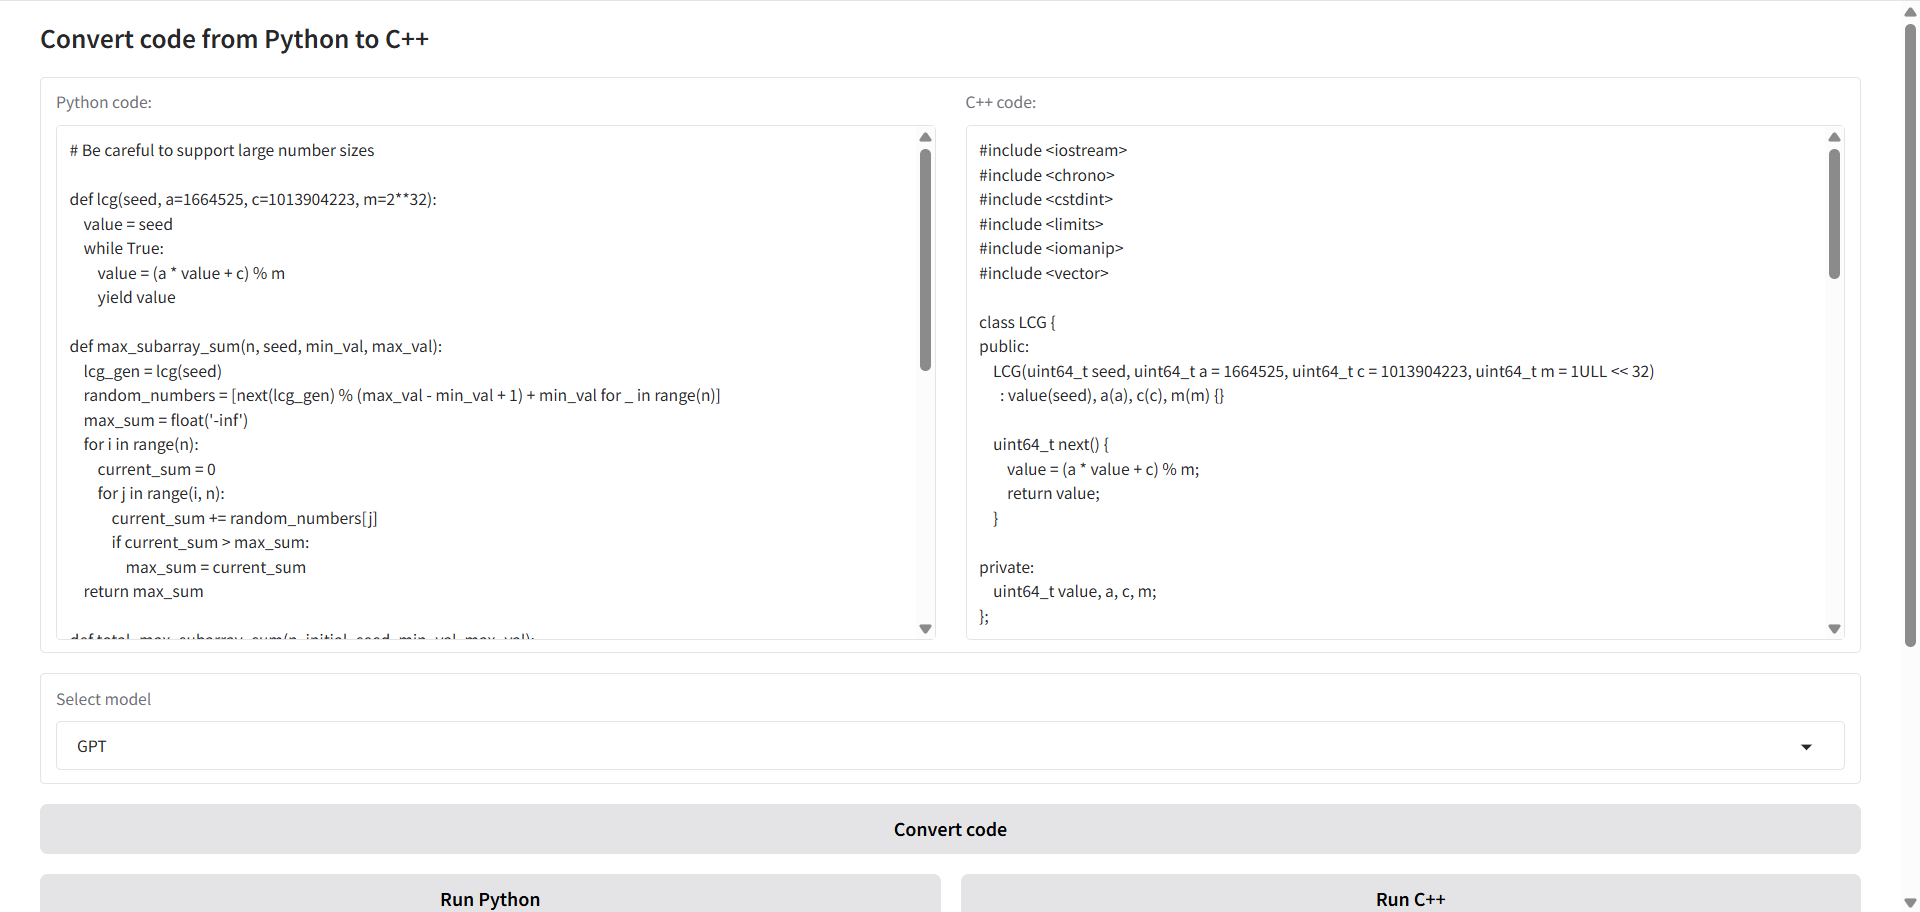

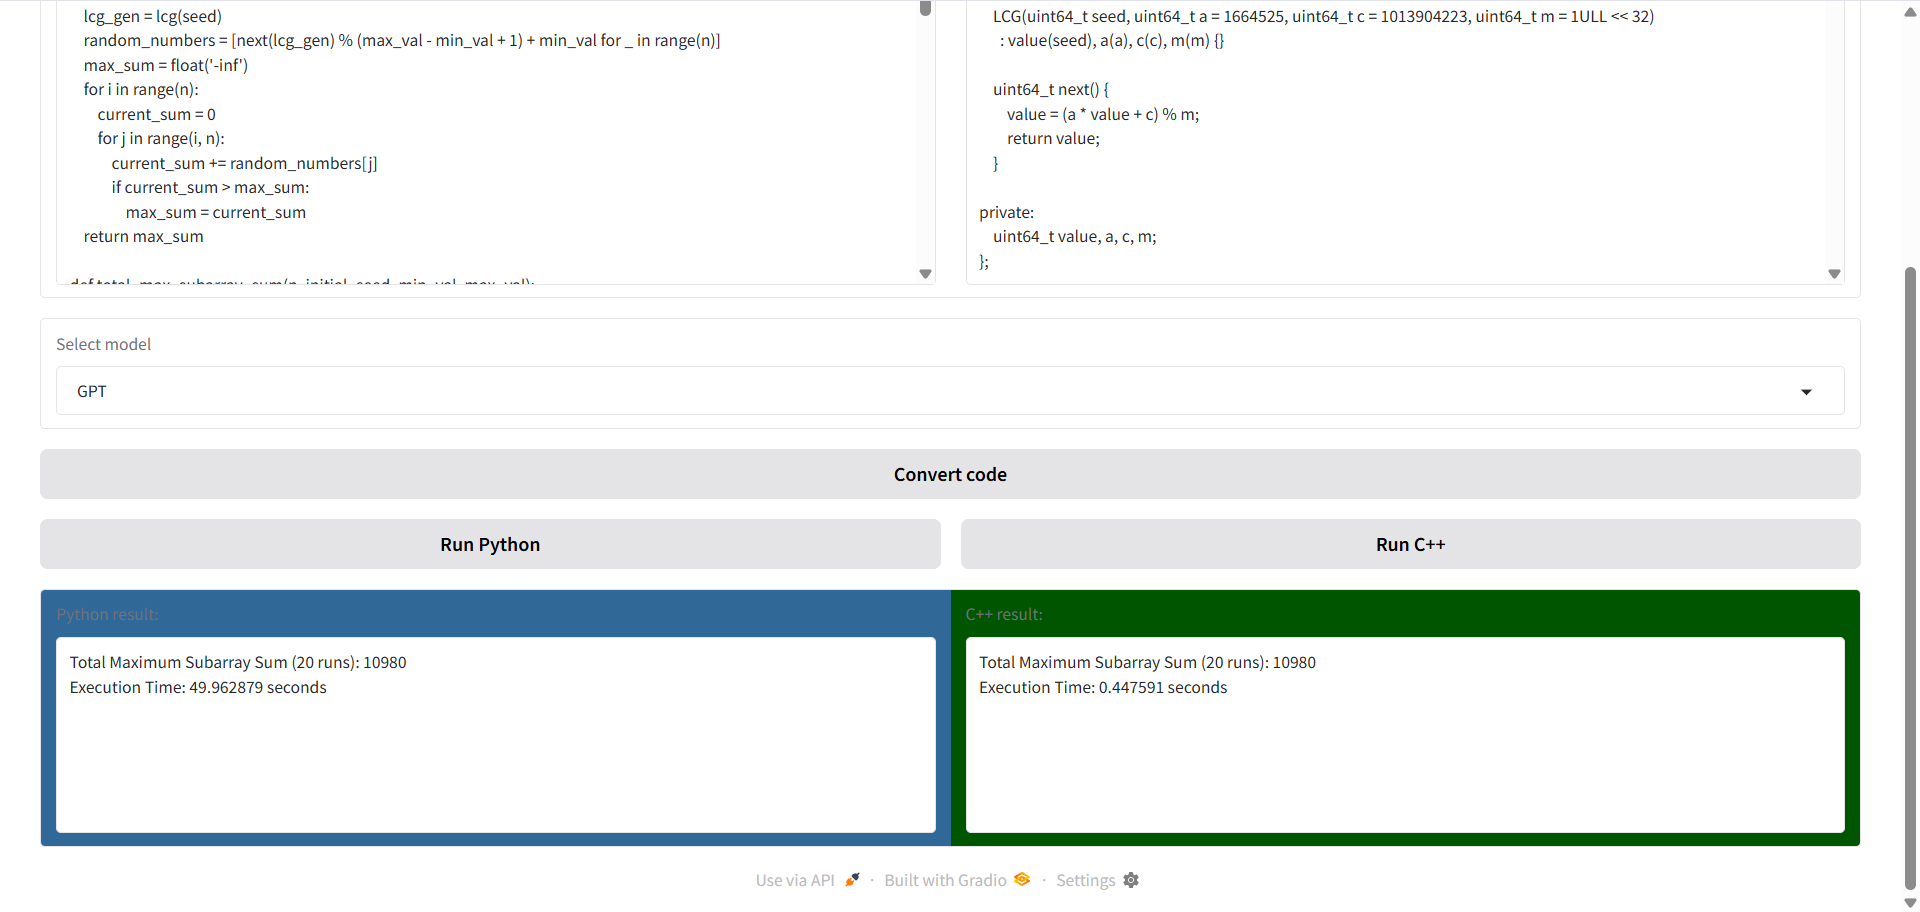

<div style="font-size: 14px; line-height: 1.5; margin: 0; padding: 0;">
<b>For <code>Llama3.2</code></b><br>
</div>

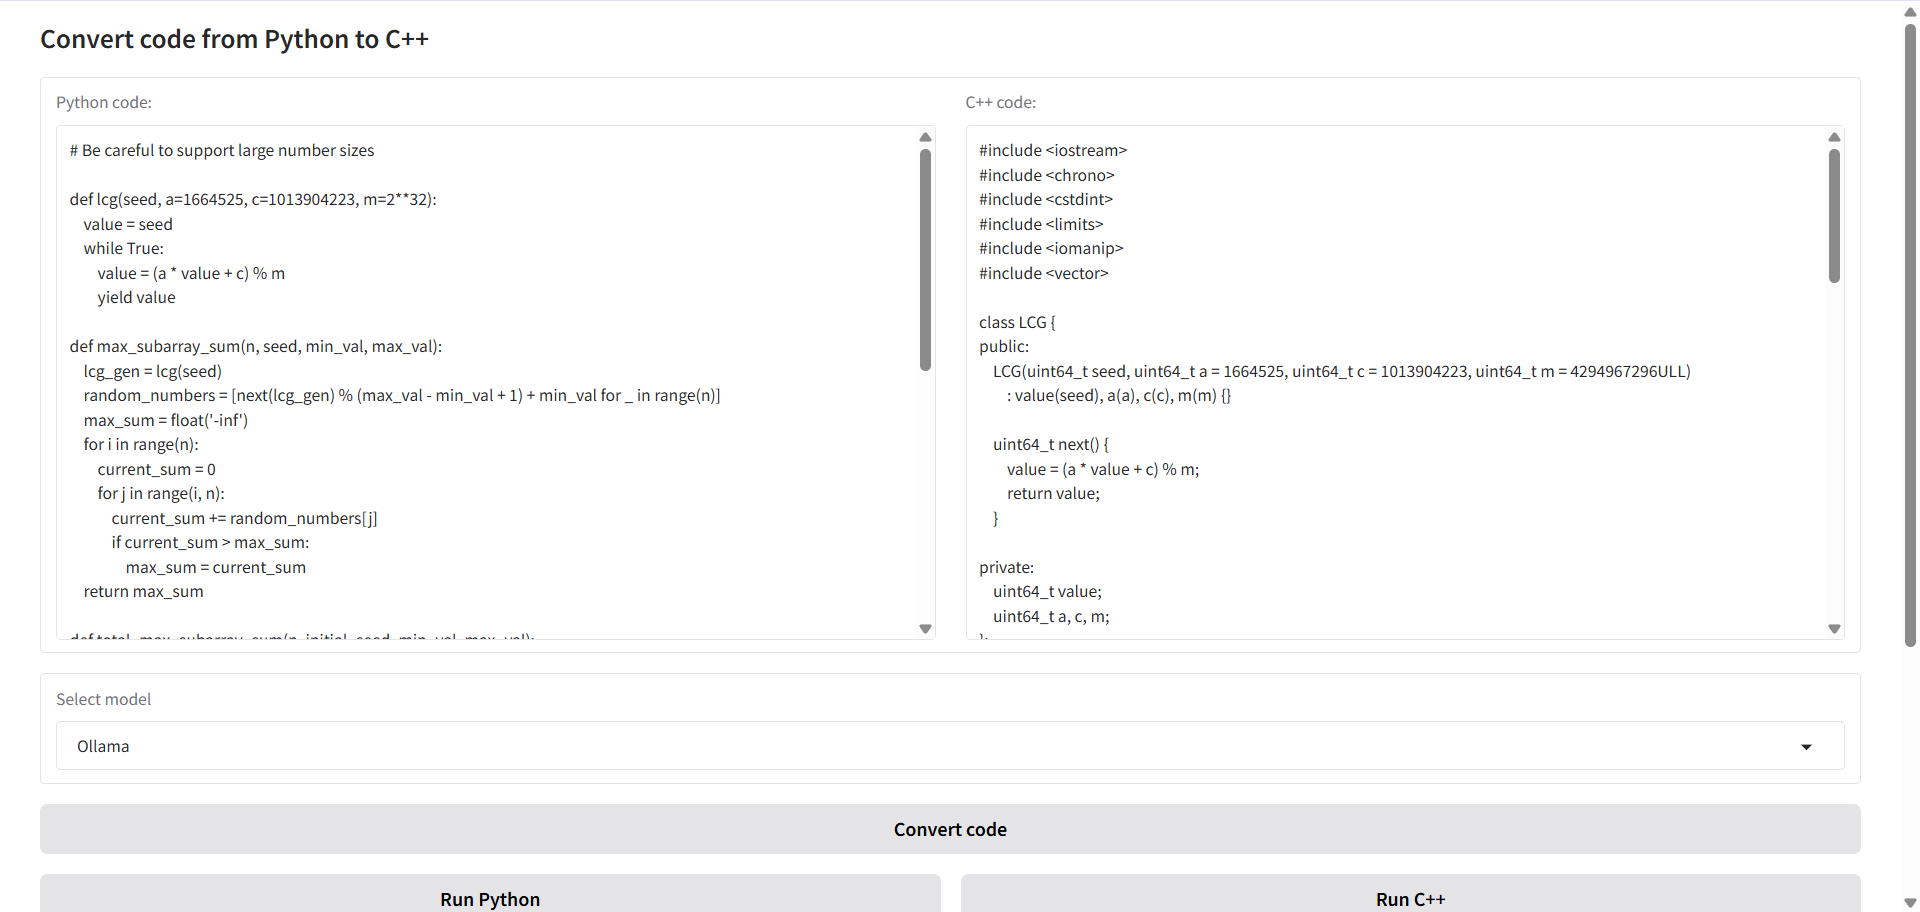

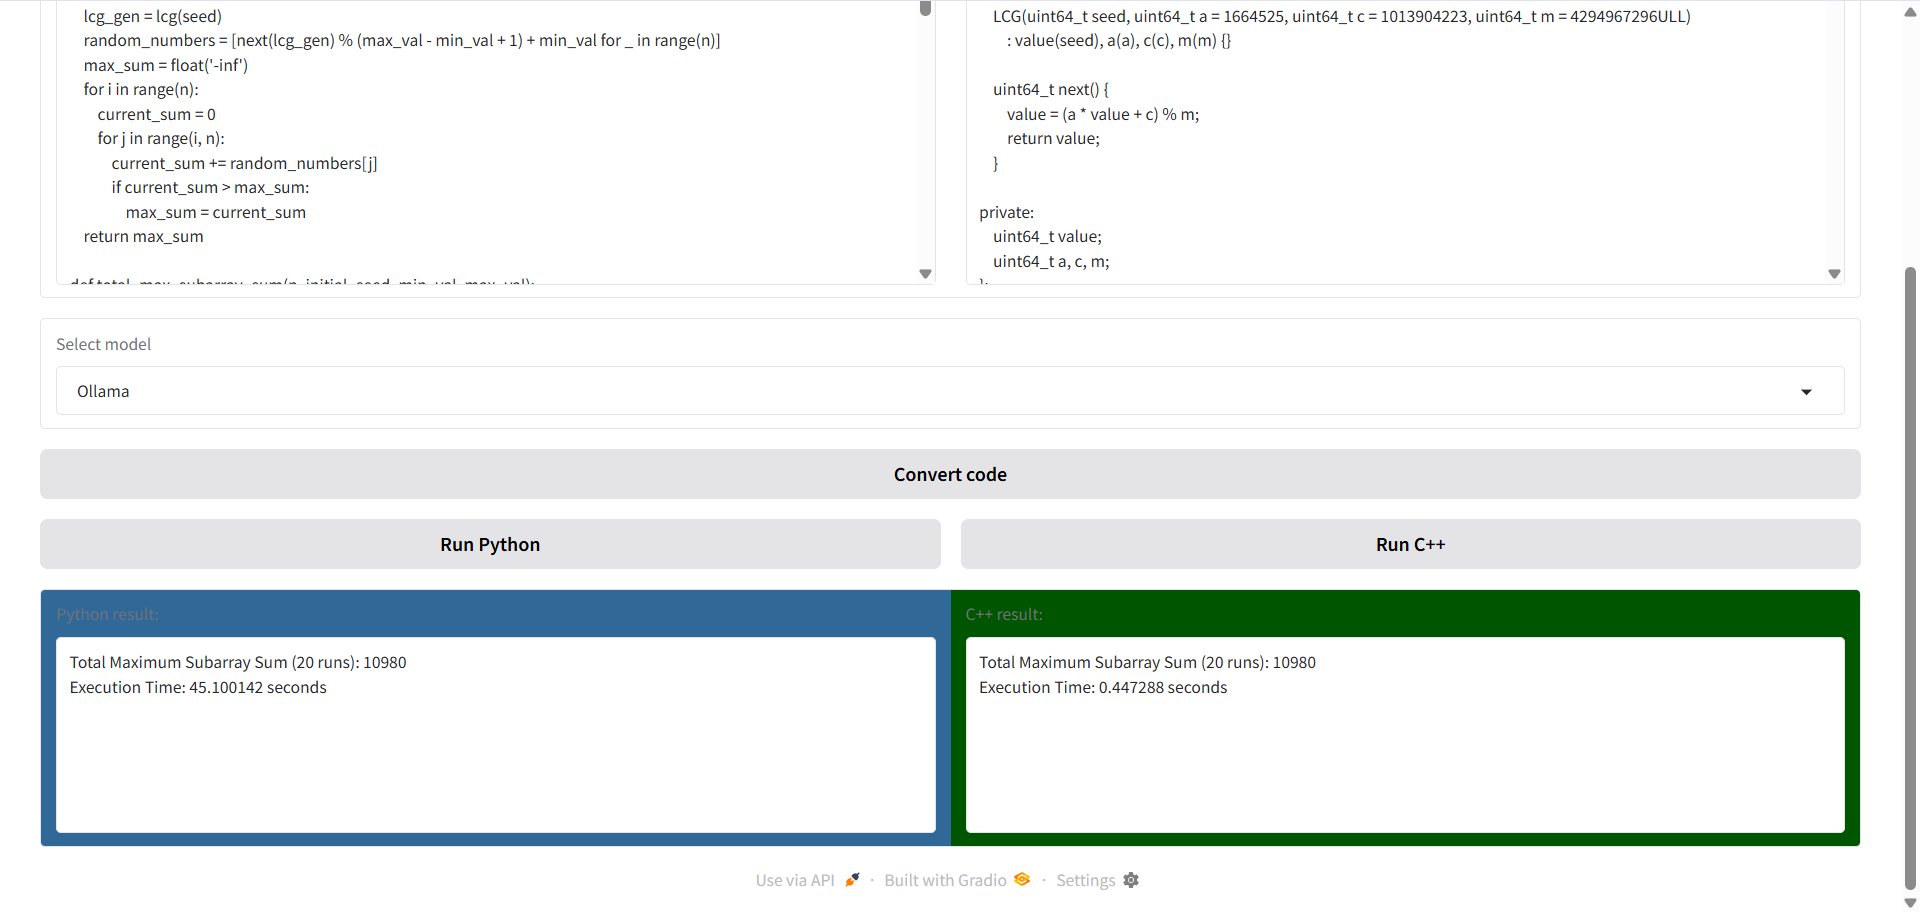

<br>

<br>

#### <code>**day4.ipynb**</code>

<div style="font-size: 14px; line-height: 1.5; margin: 0; padding: 0;">
<h5 style="margin-bottom: 0.2em; font-size: 16px;"><b>Sidenote</b></h5>
While Dr. Donner's original course uses HuggingFace Inference Endpoints (which require $10+ to be utilized), I've opted to use the <b>Google Gemini API</b> instead, authenticated via <code>.env</code> variable <code>GOOGLE_API_KEY</code>. 
</div>

<div style="font-size: 14px; line-height: 1.5; margin: 0; padding: 0;">
<h5 style="display: inline; font-size: 16px; margin-right: 0.3em;"><b>Problem 4:</b></h5>Re-run <code>day3.ipynb</code> using <b>Google Gemini <code>(gemini-1.5-flash)</code></b> as a third option
</div>


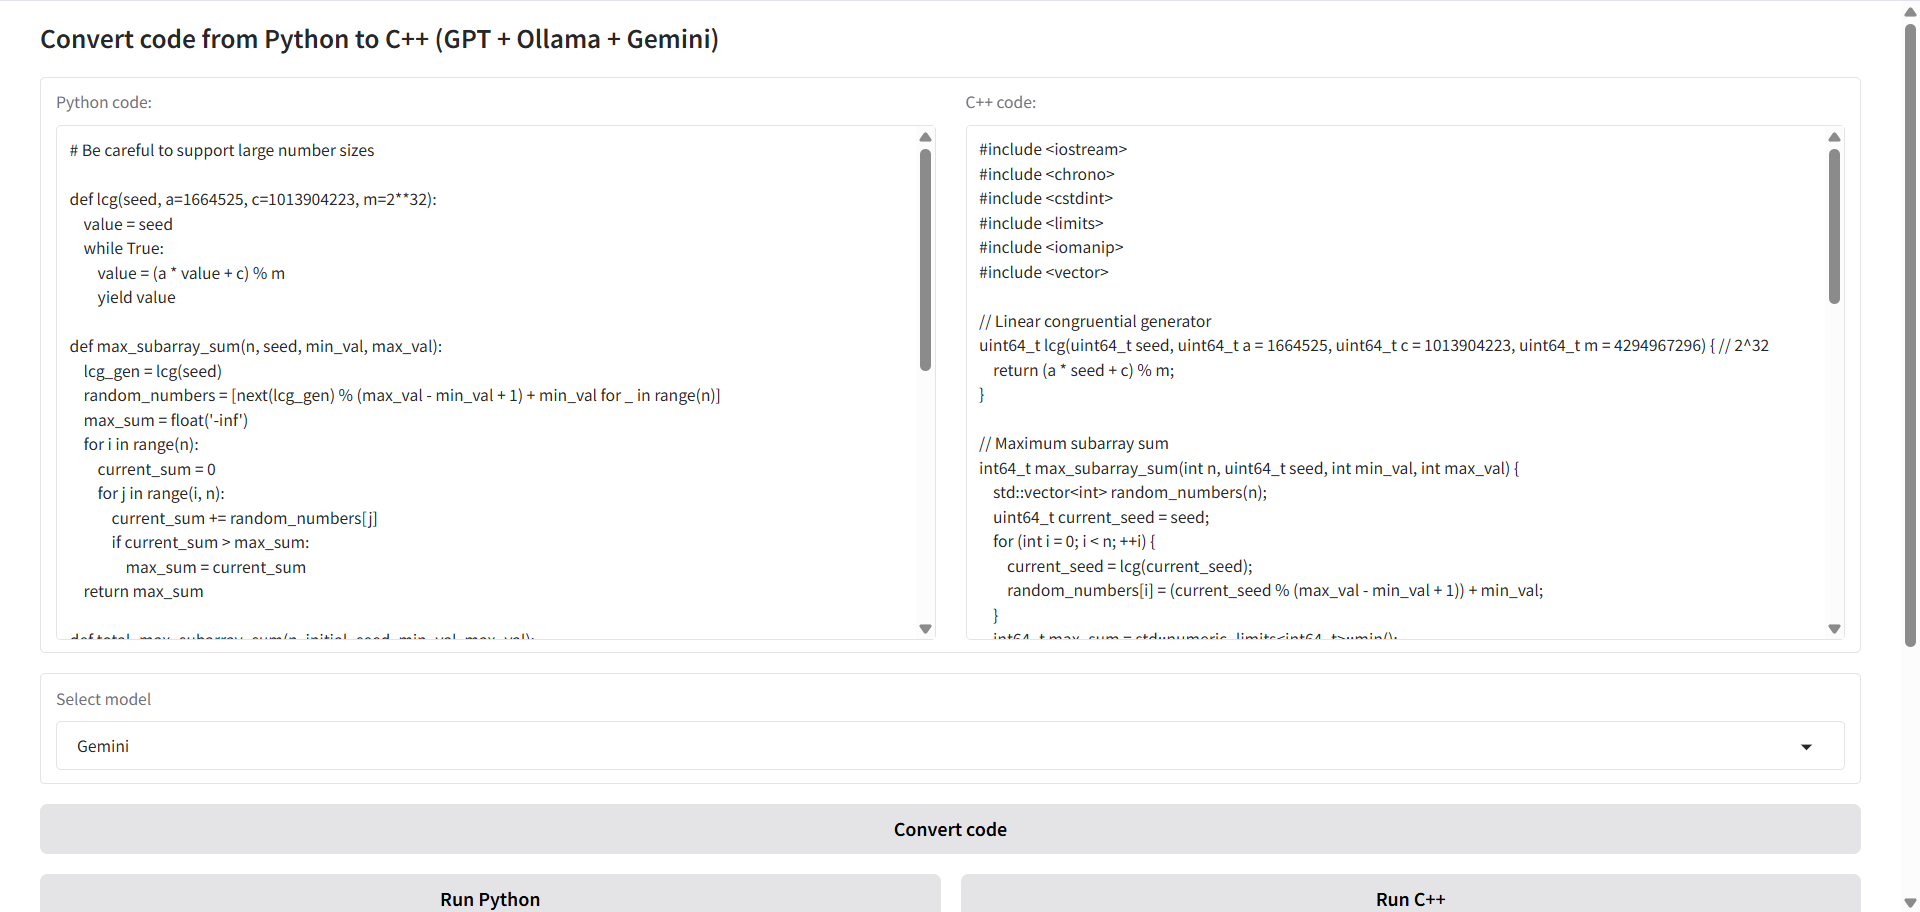

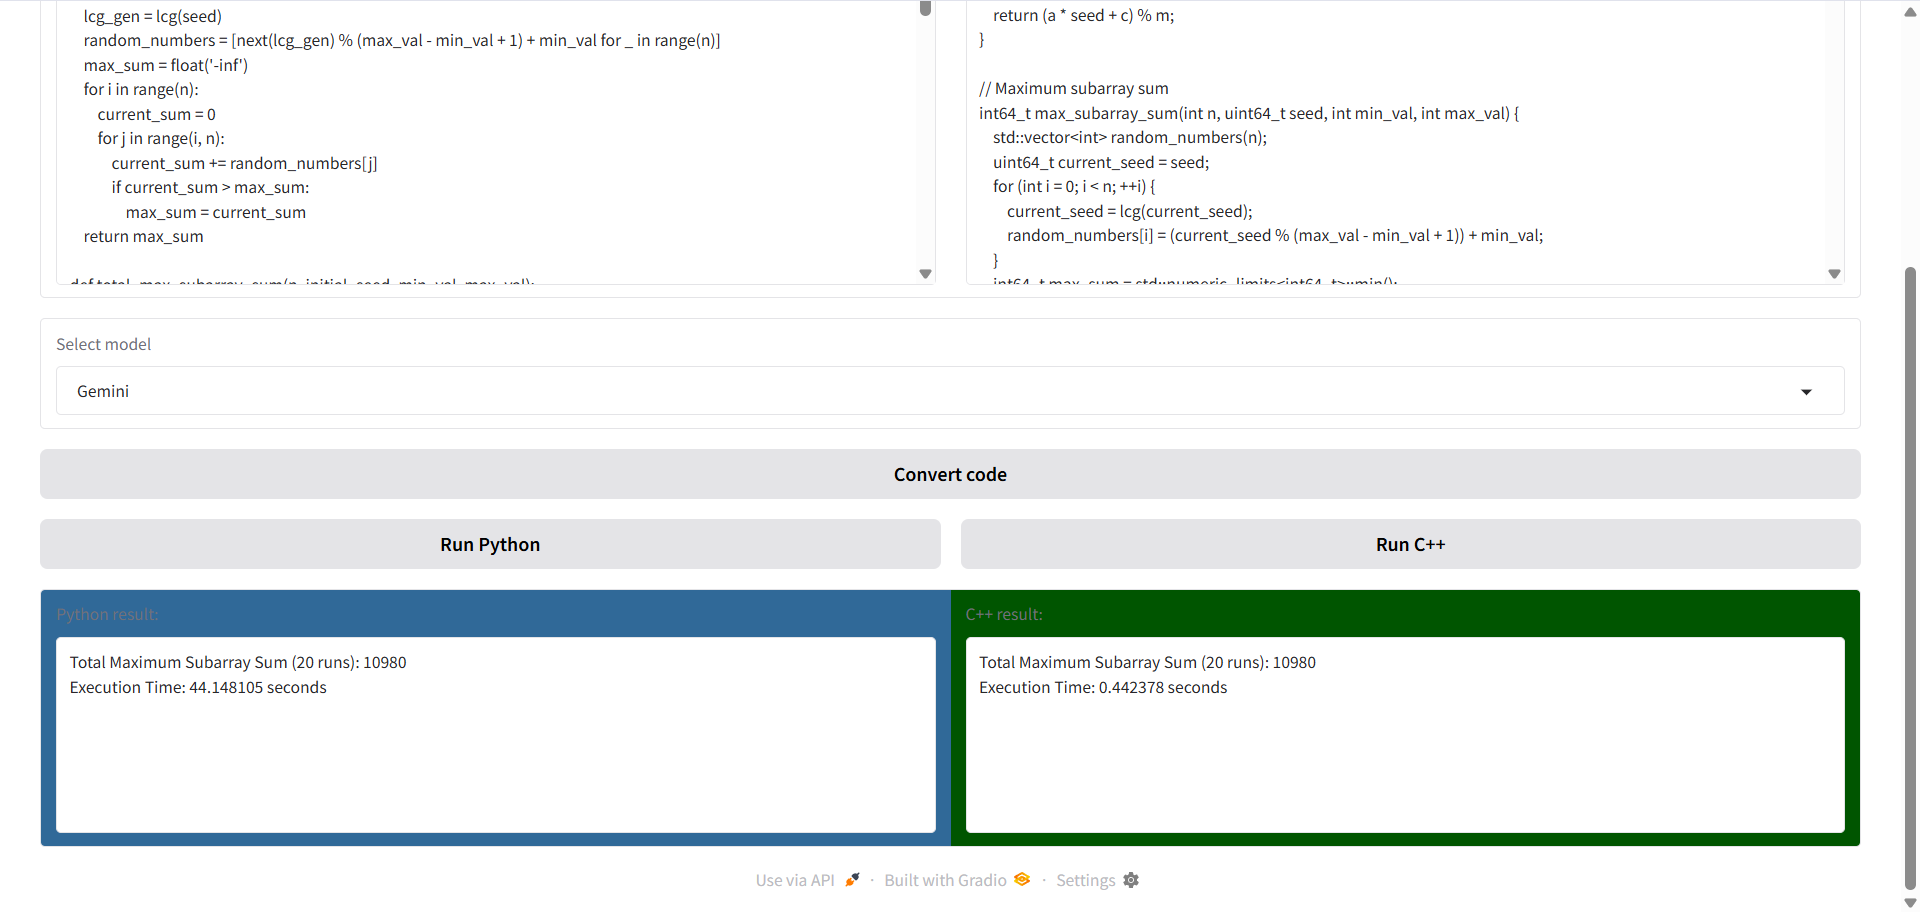